# 과제3_고객 예측결과 설명하기

* 여러분이 작성한 예측 모델에 대한 중요 요인 보고서로
    * 고객은 모델의 성능에 대해 신뢰를 갖게 되었습니다.
    * 현장 전문가들이 가지고 있는 직관과 대체로 일치하기도 했지만,
    * 생각지 못했던 변수가 중요하게 작용함을 알게 된 것은, 고객에게 신선한 충격이 되었습니다.

* 이제 운영 시스템에 배포하고 베타 오픈을 하였습니다.
    * 대출창구에서는 대출심사결과를 기다려야 하는 번거로움이 사라져서 환영하는 분위기 입니다.
    * 그런데 한가지 문제가 발생했습니다. 신용평가가 낮게 나온 고객 한 명이 강한 불만을 제기하였습니다. 자신의 대출신청이 왜 반려되었는지 이해할수 없다는 것이었습니다.
    * 현장 직원은 인공지능이 그렇게 판단했다고 이야기 하는 것이 적절한 답변이 아니라고 판단하여, 제대로 된 답변을 하지 못했습니다.

* 고객사는 다시 여러분에게 요청을 해 왔습니다. **개별 신용평가 결과에 대한 근거를 제시**해 달라는 것입니다.


## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

import shap

### 2) 데이터 로딩

In [3]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.head()

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|



* 데이터의 크기를 살펴봅시다.

In [4]:
data.shape

(1000, 17)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


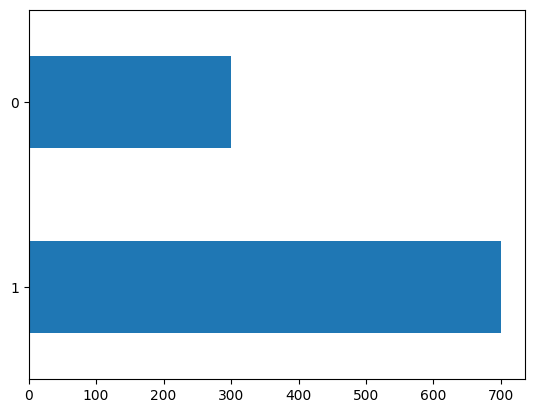

In [5]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts()/ data.shape[0])

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 1) x, y로 나누기

In [6]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [7]:
dummy_vars = ['SexMarital', 'MostValuableAsset','ForeignWorker','Telephone']

x = pd.get_dummies(x, columns = dummy_vars, drop_first = True)
x.head()

,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,0,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,0,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,2,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,1,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


### 3) train : validation 분할

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)

## 3.모델링
* 과제1,2에서 성능이 가장 좋았던 모델을 다시 생성합시다.
    * 다음 알고리즘 제외
        * XGBoost를 제외한 모델 사용(지원안됨)
        * SVM은 SHAP value를 구하는 시간이 많이 소요

In [9]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [10]:
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

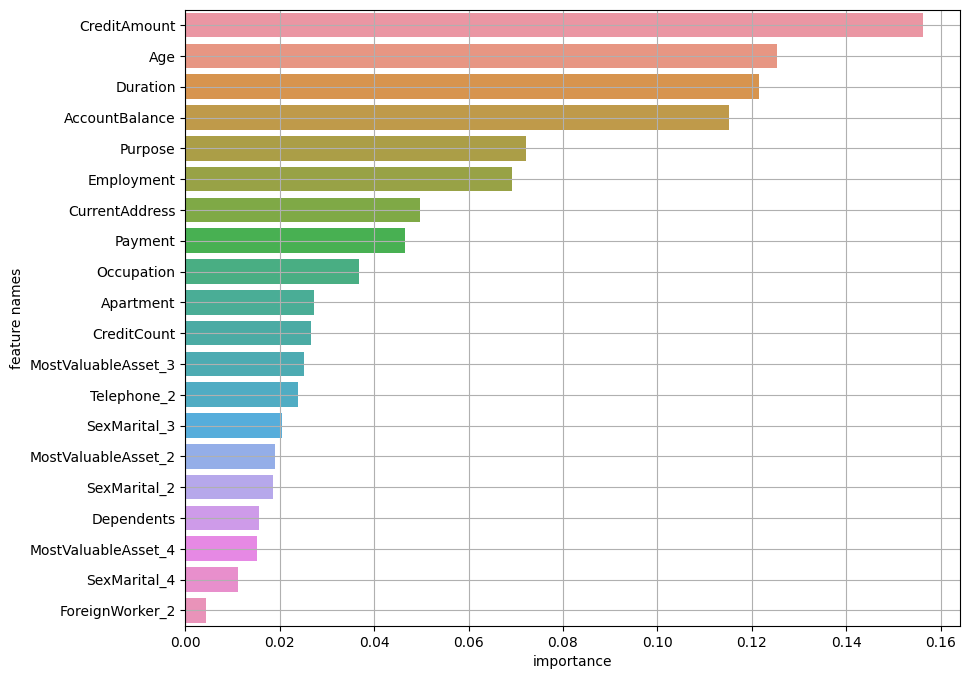

In [11]:
result = plot_feature_importance(model.feature_importances_, list(x_train))

## 4.개별 고객의 신용평가 예측 결과에 미치는 영향
* 모델을 생성한 후, validation 데이터를 운영에서 발생된 데이터로 간주하고 분석해 봅시다.
* 신용 대출 신청자중 임의로 3 ~ 4명을 선정하고, 예측결과에 영향을 준 변수에 대해 설명하시오.


In [12]:
# SHAP 값으로 모델의 예측 설명하기
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

In [13]:
explainer.expected_value

array([0.2852375, 0.7147625])

In [14]:
explainer.expected_value[1]

0.7147625000000003

In [15]:
shap_values[1]

array([[ 0.19446668, -0.00125086,  0.0035564 , ...,  0.00755842,
        -0.0015207 , -0.00661001],
       [-0.05098075,  0.06794928, -0.01235837, ...,  0.01126076,
        -0.00151791, -0.00528854],
       [-0.10147046,  0.02203711,  0.08461627, ...,  0.00669851,
        -0.00185124, -0.00712305],
       ...,
       [-0.06915158, -0.1374611 , -0.10655653, ..., -0.06522373,
        -0.0005373 ,  0.0093991 ],
       [-0.04198574,  0.05497177,  0.04004848, ...,  0.01445682,
        -0.00028514,  0.00409372],
       [ 0.12373758, -0.00163874, -0.03172319, ...,  0.0008184 ,
        -0.00217298, -0.02161884]])

In [16]:
shap.initjs()
idx = 932
shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], x.iloc[idx,:])

In [17]:
shap.initjs()
idx = 741
shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], x.iloc[idx,:])

In [18]:
shap.initjs()
idx = 917
shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], x.iloc[idx,:])

In [19]:
shap.initjs()
idx = 226
shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], x.iloc[idx,:])

In [20]:
shap.initjs()
idx = 180
shap.force_plot(explainer.expected_value[1], shap_values[1][idx, :], x.iloc[idx,:])

## 5.추가 분석
* 모델의 전체 중요도와 유사도로 정렬한 후 force_plot 결과와 비교해 봅시다.

In [21]:
x_temp = x.sample(200)
sv_temp = shap_values[1][x_temp.index]

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], sv_temp, x_temp)

* 예측값(Output value)으로 정렬한 그래프를 보며, 신용도 높은 사람과 낮은 사람의 전반적인 특징이 어떻게 달라지는지 확인해 봅시다.

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], sv_temp, x_temp)

* 두 feature의 조합과 shap value 간의 관계 그래프 dependence_plot을 그려보고 관계를 설명해 봅시다.
(최소 조합 2개 이상)

In [24]:
x.head()

,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,0,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,0,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,2,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,1,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


In [25]:
shap_values[1]

array([[ 0.19446668, -0.00125086,  0.0035564 , ...,  0.00755842,
        -0.0015207 , -0.00661001],
       [-0.05098075,  0.06794928, -0.01235837, ...,  0.01126076,
        -0.00151791, -0.00528854],
       [-0.10147046,  0.02203711,  0.08461627, ...,  0.00669851,
        -0.00185124, -0.00712305],
       ...,
       [-0.06915158, -0.1374611 , -0.10655653, ..., -0.06522373,
        -0.0005373 ,  0.0093991 ],
       [-0.04198574,  0.05497177,  0.04004848, ...,  0.01445682,
        -0.00028514,  0.00409372],
       [ 0.12373758, -0.00163874, -0.03172319, ...,  0.0008184 ,
        -0.00217298, -0.02161884]])

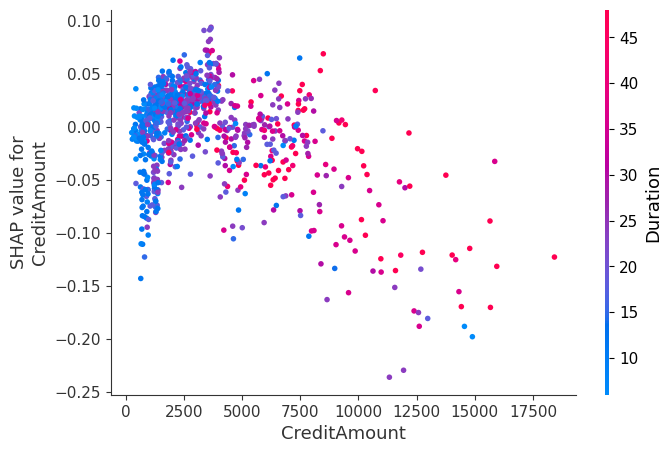

In [26]:
shap.dependence_plot('CreditAmount', shap_values[1], x, interaction_index = 'Duration')